### Project 1 | Computer Vision with CNN

Plant seedings classification

#### Load the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skimage.transform import resize as imresize

import os

import tensorflow as tf
import keras

from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import  Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from PIL import Image 

from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Mount the drive for loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# un-zip the archive
# !unzip -uq "/content/drive/My Drive/Dataset/plant-seedlings-classification" -d "/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN"


In [3]:
# walt-through/browse the un-zipped folder
!ls "/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN"

sample_submission.csv  test  train


In [4]:
# Understand the size
!du -h "/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train"

259M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Black-grass
151M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Charlock
51M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Cleavers
72M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Common Chickweed
91M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Common wheat
95M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Fat Hen
310M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Loose Silky-bent
126M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Maize
73M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Scentless Mayweed
50M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Shepherds Purse
112M	/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/Small-flowered Cranesbi

In [5]:
# using the linux cmd understand the no of image files
!find "/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train/" -type f -print | wc -l

4750


In [6]:
# Read the sub-dirs under train-dir which form the labels/classes for the given problem
data_root_dir = "/content/drive/My Drive/Dataset/plant-seedlings-classification-CNN/train"
sub_dirs = os.listdir(data_root_dir)
print('Sub-directory alias labels:\n',sub_dirs)

Sub-directory alias labels:
 ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


#### Read the images

In the given data-set total count of images under train directory are 4750

Total no of images are 4750, labels are 4750



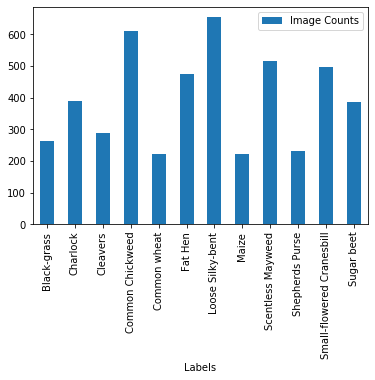

,Name,Labels,Size
4074,68ac98ab6.png,Small-flowered Cranesbill,"(193, 193)"
179,af1b91028.png,Black-grass,"(1009, 1009)"
1310,92bd3b2b7.png,Common Chickweed,"(410, 410)"
2490,5fda67f10.png,Loose Silky-bent,"(155, 155)"
1099,387ad12e8.png,Common Chickweed,"(177, 177)"


In [7]:
# For the given problem, the test data-set doesn't have label, whereas the images in the train dir(aka it's sub-dir) can be labeled from the sub-dir name it is in.
# Here, images from the train dir is consider for training as wells as for evaluation.

img_data = []
img_label = []
img_count = []
img_size = []
img_name_ref = []

img_input_shape = (50,50,3)

# Directory walk-through
for curr_dir in sub_dirs:
  pres_dir = os.path.join(data_root_dir, curr_dir)
  
  # Get the images from the sub-dir
  for dirpath, dirnames, filenames in os.walk(pres_dir):
    a = 0

    # Cumulate the images and it's label
    for img_file in filenames:
      im = Image.open(os.path.join(pres_dir,img_file))
      img_size.append(im.size)
      
      im = img_to_array(im)
      #im = im.resize(input_dim )
      im = imresize(im, img_input_shape )
      
      img_data.append(im)
      img_label.append(str(str(pres_dir).split('/')[-1]))
      
      img_name_ref.append(img_file)
      
      a=a+1

    img_count.append(a)

print('In the given data-set total count of images under train directory are {}\n'.format(sum(img_count)))
print('Total no of images are {}, labels are {}\n'.format(len(img_data), len(img_label)))

sub_dirs_label_img_cnt = {'Labels':sub_dirs, 'Image Counts':img_count}
pd.DataFrame(data=sub_dirs_label_img_cnt).plot.bar(x='Labels')
plt.show()

img_Details = {'Name':img_name_ref, 'Labels':img_label, 'Size':img_size}
plant_seed_img_df = pd.DataFrame(data=img_Details)
plant_seed_img_df.sample(5)

#### Understand the datasets shape, dimesnions, size etc.

In [8]:
print ('Image min & max size are {} {}\n'.format( min(plant_seed_img_df['Size']), max(plant_seed_img_df['Size'])))
print ('No of uniques size field for the given data-set {}\n'.format(plant_seed_img_df['Size'].nunique()))

Image min & max size are (49, 49) (3991, 3457)

No of uniques size field for the given data-set 1007



In [9]:
plant_seed_img_df.pivot_table(index=['Size'],columns='Labels', aggfunc='count').T

Size                            (49, 49)  (51, 51)  ...  (3652, 3457)  (3991, 3457)
     Labels                                         ...                            
Name Black-grass                     NaN       NaN  ...           NaN           NaN
     Charlock                        NaN       NaN  ...           NaN           NaN
     Cleavers                        NaN       NaN  ...           NaN           NaN
     Common Chickweed                NaN       NaN  ...           NaN           NaN
     Common wheat                    NaN       1.0  ...           NaN           NaN
     Fat Hen                         NaN       NaN  ...           NaN           NaN
     Loose Silky-bent                NaN       NaN  ...           1.0           1.0
     Maize                           NaN       NaN  ...           NaN           NaN
     Scentless Mayweed               2.0       3.0  ...           NaN           NaN
     Shepherds Purse                 NaN       NaN  ...           NaN           NaN
     Small-flowered Cranesbill       NaN       NaN  ...           NaN           NaN
     Sugar beet                      1.0       NaN  ...           NaN           NaN

[12 rows x 1007 columns]

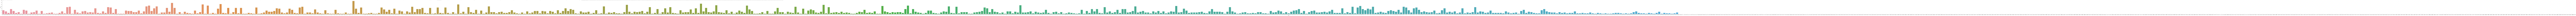

In [10]:
fig, ax = plt.subplots(1,1, figsize=(901,5))
sns.countplot(data=plant_seed_img_df, x='Size', ax=ax)
plt.show()

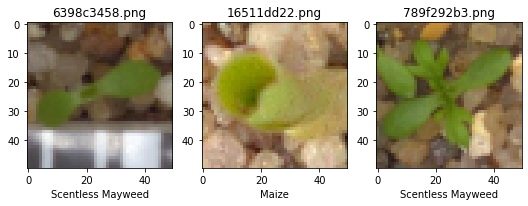

In [11]:
rnd_no = np.random.randint(4750,size=3)

j=1
plt.figure(figsize=(12,7))

for idx in rnd_no:
  plt.subplot(1,4,j)
  plt.imshow( array_to_img(img_data[idx]))
  plt.xlabel(img_label[idx])
  plt.title(img_name_ref[idx])
  j=j+1

plt.show()

#### Encode the labels

In [0]:
labelEncoder = LabelEncoder()
labelEncoder.fit(img_label)
train_labels_encoded = labelEncoder.transform(img_label)

#### Split the data-set into train/test

In [0]:
x_train,x_test, y_train, y_test = train_test_split(np.asarray(img_data),train_labels_encoded, test_size=0.20, random_state=3)


In [0]:
# standardize / normalise
x_train = x_train/255
x_test = x_test /255

In [15]:
x_train.shape


(3800, 50, 50, 3)

In [16]:
y_train[0:5]

array([11,  9,  3, 10, 11])

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=12)

In [18]:
y_train[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [21]:
def model_1():
  conv_input_shape = img_input_shape
  EPOCHS = 100

  # create the model
  model = Sequential()

  # add a convolution layer with padding
  model.add(Conv2D(128, (3, 3), padding='same', input_shape=conv_input_shape)) 
  model.add(Activation("relu"))

  # add a pool layer
  model.add(MaxPooling2D(pool_size=(2, 2)))

  #model.add(Conv2D(64, (3, 3), padding='same', input_shape=conv_input_shape)) 
  #model.add(Activation("relu"))

  #model.add(MaxPooling2D(pool_size=(2, 2)))

  #model.add(Conv2D(32, (5, 5), padding='same'))
  #model.add(Activation("relu"))

  #model.add(MaxPooling2D(pool_size=(2, 2)))

  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  #model.add(Conv2D(32, (3, 3), padding='same'))
  #model.add(Activation("relu"))
  #model.add(MaxPooling2D(pool_size=(2, 2)))

  # flatten the i/p for NN
  model.add(Flatten())

  # add a dense layer with activation funtion relu
  model.add(Dense(units=128))
  model.add(Activation("relu"))

  #model.add(Dense(units=64))
  #model.add(Activation("relu"))


  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  # output layer
  model.add(Dense(units=12))
  model.add(Activation("softmax"))

  model.summary()

  #opt = keras.optimizers.SGD(lr=0.01, momentum=0.0,clipvalue=0.5, nesterov=False)
  #opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
  opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'] )

  epochs = EPOCHS

  #Adding Early stopping callback to the fit function is going to stop the training,
  #if the val_loss is not going to change even '0.001' for more than 10 continous epochs
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

  m1_his = model.fit(x_train, y_train, epochs=epochs, verbose=0, validation_split=0.20, callbacks=[early_stopping])          

  test_loss, test_acc = model.evaluate(x_test,y_test, verbose=0)   
  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)
  return m1_his

m1_his = model_1()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 50, 50, 128)       3584      
_________________________________________________________________
activation_11 (Activation)   (None, 50, 50, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               10240128  
_________________________________________________________________
activation_12 (Activation)   (None, 128)              

In [31]:
def model_2():
  conv_input_shape = img_input_shape
  EPOCHS = 100

  model = Sequential()

  model.add(Conv2D(128, (3, 3), padding='same', input_shape=conv_input_shape)) 
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=conv_input_shape)) 
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (5, 5), padding='same'))
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(units=128))
  model.add(Activation("relu"))

  model.add(Dense(units=64))
  model.add(Activation("relu"))

  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  model.add(Dense(units=12))
  model.add(Activation("softmax"))

  model.summary()

  opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'] )

  epochs = EPOCHS

  #Adding Early stopping callback to the fit function is going to stop the training,
  #if the val_loss is not going to change even '0.001' for more than 10 continous epochs
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

  m2_his = model.fit(x_train, y_train, epochs=epochs, verbose=0, validation_split=0.20, callbacks=[early_stopping])          

  test_loss, test_acc = model.evaluate(x_test,y_test, verbose=0)   
  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)

  return m2_his

m2_his= model_2()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 50, 50, 128)       3584      
_________________________________________________________________
activation_42 (Activation)   (None, 50, 50, 128)       0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 64)        73792     
_________________________________________________________________
activation_43 (Activation)   (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 32)       

In [33]:
def model_3():
  conv_input_shape = img_input_shape
  EPOCHS = 100

  model = Sequential()

  model.add(Conv2D(128, (3, 3), padding='same', input_shape=conv_input_shape)) 
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=conv_input_shape)) 
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (5, 5), padding='same'))
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(units=128))
  model.add(Activation("relu"))

  model.add(Dense(units=64))
  model.add(Activation("relu"))

  #Apply Dropout with 0.25 probability 
  model.add(Dropout(0.25))

  model.add(Dense(units=12))
  model.add(Activation("softmax"))

  model.summary()

  opt = keras.optimizers.sgd(lr=0.001, momentum=0.0)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'] )

  epochs = EPOCHS

  #Adding Early stopping callback to the fit function is going to stop the training,
  #if the val_loss is not going to change even '0.001' for more than 10 continous epochs
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

  m3_his = model.fit(x_train, y_train, epochs=epochs, verbose=0, validation_split=0.20, callbacks=[early_stopping])          

  test_loss, test_acc = model.evaluate(x_test,y_test, verbose=0)   
  print("Model - test loss:", test_loss * 100)
  print("Model - test accuracy:", test_acc * 100)

  return m3_his

m3_his= model_3()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 50, 50, 128)       3584      
_________________________________________________________________
activation_56 (Activation)   (None, 50, 50, 128)       0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 25, 25, 64)        73792     
_________________________________________________________________
activation_57 (Activation)   (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 32)      

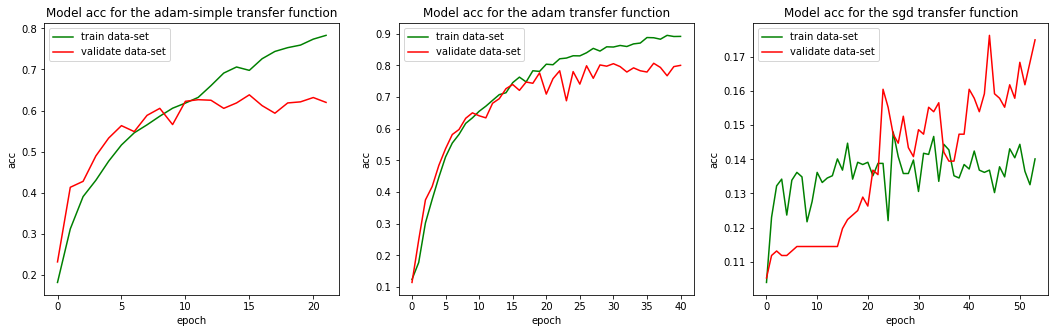

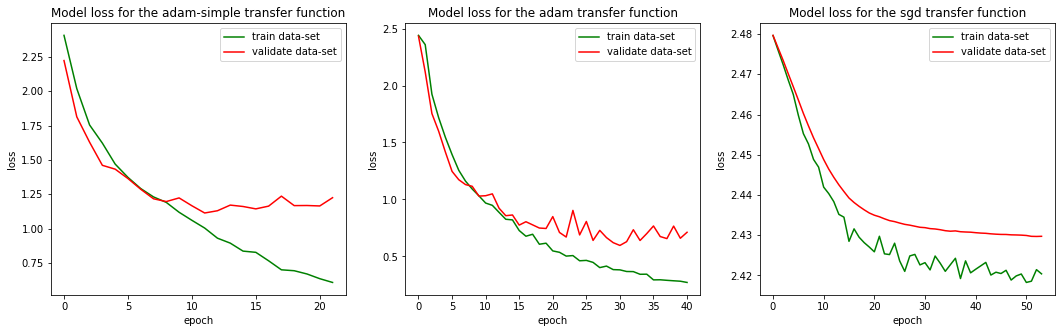

In [35]:
def plot_model_history(ax, history, train_metric, val_metric, actv_func ):
  ax.plot(history[train_metric], 'green',label='train data-set')
  ax.plot(history[val_metric], 'red',label='validate data-set')
  ax.set_title('Model {} for the {} transfer function'.format(train_metric,actv_func))
  ax.set_ylabel(train_metric)
  ax.set_xlabel('epoch')
  ax.legend()


fig, ax = plt.subplots(1, 3, figsize=(18,5))
plot_model_history(ax[0], m1_his.history, 'acc', 'val_acc', 'adam-simple')
plot_model_history(ax[1], m2_his.history, 'acc', 'val_acc', 'adam')
plot_model_history(ax[2], m3_his.history, 'acc', 'val_acc', 'sgd')


fig, ax = plt.subplots(1, 3, figsize=(18,5))
plot_model_history(ax[0], m1_his.history, 'loss', 'val_loss', 'adam-simple')
plot_model_history(ax[1], m2_his.history, 'loss', 'val_loss', 'adam')
plot_model_history(ax[2], m3_his.history, 'loss', 'val_loss', 'sgd')


plt.show()

Inferences:
    * Model_1 is a simple model, where 1 convolution layer with filter/pool/dropout connected to 1 dense layer, here the accuracy is low while compared to model2  
    * Model2 where adding more convolution layer/ dense layer increase the accuracy.
    * For the given data-set activation function 'adam' is better than other functions

Without any image pre-processing for model_2 with activation function adam the accuracy is 81%.

Note: 

In this example image are not preprocessed. Applying any image preprocessing steps may improve the accuracy. It was pre-processed as am in the process of understanding those techniques.

Performing GridsearchCV takes long time and even session disconnects. Hence, the values for hyparameters are assigned randomly.
    
    
    

### EOF